In [10]:
import pandas as pd

In [12]:
medical_df = pd.read_csv('medical.csv')

In [16]:
medical_df

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


In [26]:
import plotly.express as px
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [28]:
sns.set_style('darkgrid')
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['figure.figsize']=(10,6)
matplotlib.rcParams['figure.facecolor'] = '#00000000'

Age
Age is a numeric column. The minimum age in the dataset is 18 and the maximum age is 64. Thus, we can visualize the distribution of age using a histogram with 47 bins (one for each year) and a box plot. We'll use plotly to make the chart interactive, but you can create similar charts using Seaborn.

In [30]:
medical_df.age.describe()

count    1338.000000
mean       39.207025
std        14.049960
min        18.000000
25%        27.000000
50%        39.000000
75%        51.000000
max        64.000000
Name: age, dtype: float64

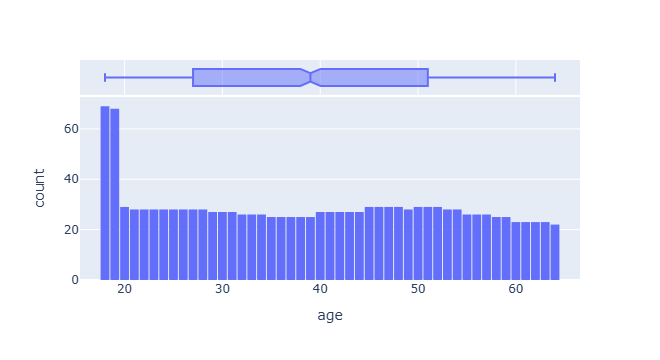

In [56]:
fid = px.histogram(medical_df,x='age',marginal='box',nbins=47)
fid.update_layout(bargap=0.1)
fid.show()

The distribution of ages in the dataset is almost uniform, with 20-30 customers at every age, except for the ages 18 and 19, which seem to have over twice as many customers as other ages. The uniform distribution might arise from the fact that there isn't a big variation in the number of people of any given age (between 18 & 64) in the USA.

EXERCISE: Can you explain why there are over twice as many customers with ages 18 and 19, compared to other ages?

???

Body Mass Index
Let's look at the distribution of BMI (Body Mass Index) of customers, using a histogram and box plot.

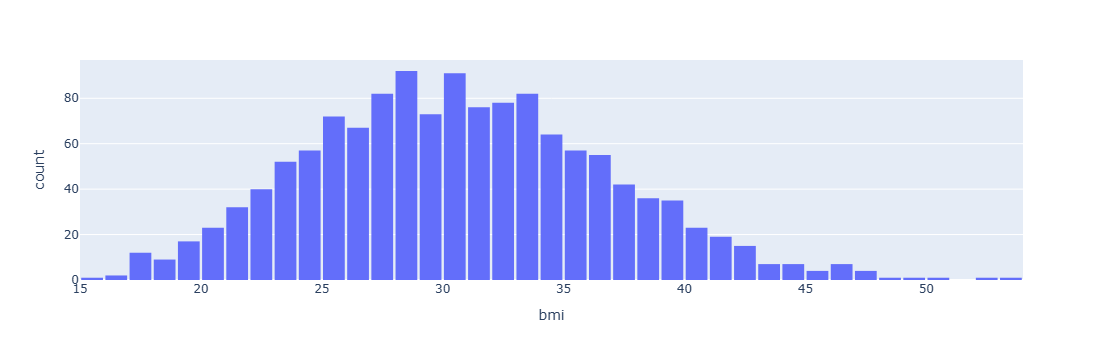

In [68]:
fid=px.histogram(medical_df,x='bmi')
fid.update_layout(bargap=0.1)
fid.show()

Charges
Let's visualize the distribution of "charges" i.e. the annual medical charges for customers. This is the column we're trying to predict. Let's also use the categorical column "smoker" to distinguish the charges for smokers and non-smokers.

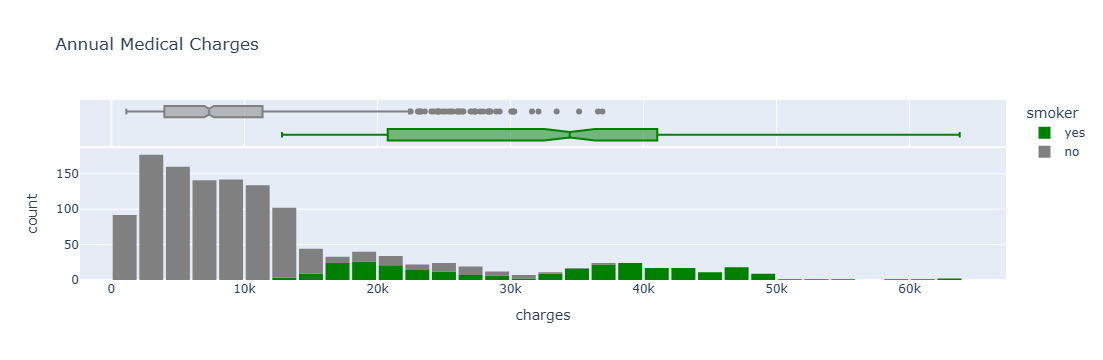

In [77]:
fig = px.histogram(medical_df, 
                   x='charges', 
                   marginal='box', 
                   color='smoker', 
                   color_discrete_sequence=['green', 'grey'], 
                   title='Annual Medical Charges')
fig.update_layout(bargap=0.1)
fig.show()

Age and Charges
Let's visualize the relationship between "age" and "charges" using a scatter plot. Each point in the scatter plot represents one customer. We'll also use values in the "smoker" column to color the points.

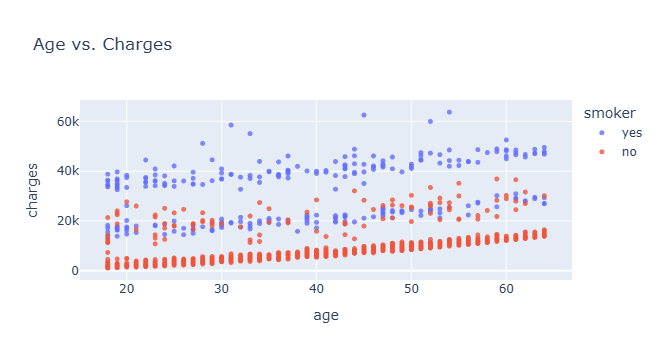

In [82]:
fig = px.scatter(medical_df, 
                 x='age', 
                 y='charges', 
                 color='smoker', 
                 opacity=0.8, 
                 
                 title='Age vs. Charges')
fig.update_traces(marker_size=5)
fig.show()

We can make the following observations from the above chart:

The general trend seems to be that medical charges increase with age, as we might expect. However, there is significant variation at every age, and it's clear that age alone cannot be used to accurately determine medical charges.

We can see three "clusters" of points, each of which seems to form a line with an increasing slope:

The first and the largest cluster consists primary of presumably "healthy non-smokers" who have relatively low medical charges compared to others

The second cluster contains a mix of smokers and non-smokers. It's possible that these are actually two distinct but overlapping clusters: "non-smokers with medical issues" and "smokers without major medical issues".

The final cluster consists exclusively of smokers, presumably smokers with major medical issues that are possibly related to or worsened by smoking.

EXERCISE: What other inferences can you draw from the above chart?

???

corralation


In [89]:
medical_df.charges.corr(medical_df.age)

0.2990081933306476

In [ ]:
medical_df.charges.corr(medical_df.bmi)

In [93]:
medical_df.charges.corr(medical_df.	children)

0.06799822684790487

In [95]:
sm={ 'no':0 , 'yes':1}
sn=medical_df.smoker.map(sm)

In [99]:
sn

0       1
1       0
2       0
3       0
4       0
       ..
1333    0
1334    0
1335    0
1336    0
1337    1
Name: smoker, Length: 1338, dtype: int64

In [105]:
medical_df.charges.corr(sn)

0.7872514304984767

Strength: The greater the absolute value of the correlation coefficient, the stronger the relationship.

The extreme values of -1 and 1 indicate a perfectly linear relationship where a change in one variable is accompanied by a perfectly consistent change in the other. For these relationships, all of the data points fall on a line. In practice, you won’t see either type of perfect relationship.

A coefficient of zero represents no linear relationship. As one variable increases, there is no tendency in the other variable to either increase or decrease.

When the value is in-between 0 and +1/-1, there is a relationship, but the points don’t all fall on a line. As r approaches -1 or 1, the strength of the relationship increases and the data points tend to fall closer to a line.

Direction: The sign of the correlation coefficient represents the direction of the relationship.

Positive coefficients indicate that when the value of one variable increases, the value of the other variable also tends to increase. Positive relationships produce an upward slope on a scatterplot.

Negative coefficients represent cases when the value of one variable increases, the value of the other variable tends to decrease. Negative relationships produce a downward slope.

Here's the same relationship expressed visually (source):

alt
The correlation coefficient has the following formula:

alt
You can learn more about the mathematical definition and geometric interpretation of correlation here: https://www.youtube.com/watch?v=xZ_z8KWkhXE

Pandas dataframes also provide a .corr method to compute the correlation coefficients between all pairs of numeric columns.

Linear Regression using a Single Feature
We now know that the "smoker" and "age" columns have the strongest correlation with "charges". Let's try to find a way of estimating the value of "charges" using the value of "age" for non-smokers. First, let's create a data frame containing just the data for non-smokers.

<Axes: xlabel='age', ylabel='charges'>

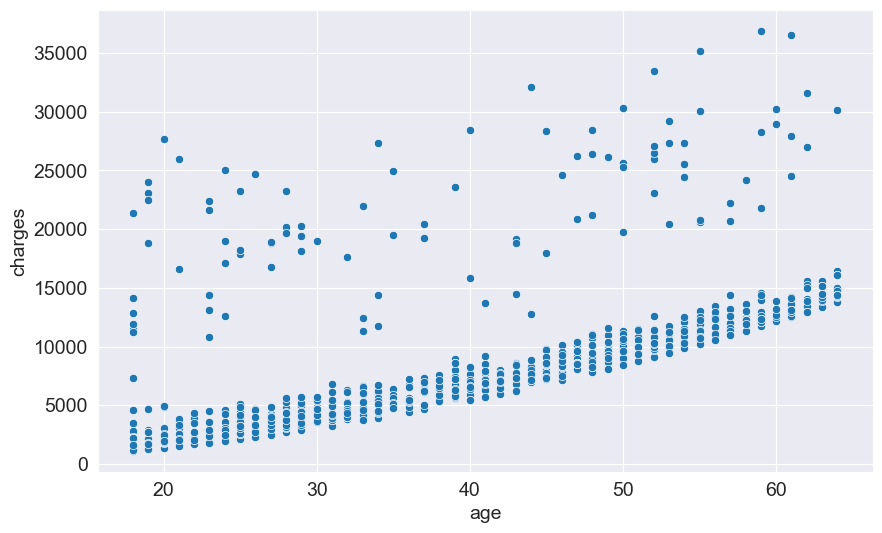

In [121]:
non_smoker_df=medical_df[medical_df.smoker =='no']
sns.scatterplot(data=non_smoker_df,x='age',y='charges')

Apart from a few exceptions, the points seem to form a line. We'll try and "fit" a line using this points, and use the line to predict charges for a given age. A line on the X&Y coordinates has the following formula:

y=wx+b
y=wx+b

The line is characterized two numbers: w
w (called "slope") and b
b (called "intercept").

Model
In the above case, the x axis shows "age" and the y axis shows "charges". Thus, we're assume the following relationship between the two:



In [192]:
def estimate_charges(age,w,b):
    return w*age+b
w = 220
b = 100





In [146]:
ages=non_smoker_df.age
ages


1       18
2       28
3       33
4       32
5       31
        ..
1332    52
1333    50
1334    18
1335    18
1336    21
Name: age, Length: 1064, dtype: int64

In [194]:
 estimated_charges = estimate_charges(ages, w, b)
estimated_charges

1        4060
2        6260
3        7360
4        7140
5        6920
        ...  
1332    11540
1333    11100
1334     4060
1335     4060
1336     4720
Name: age, Length: 1064, dtype: int64

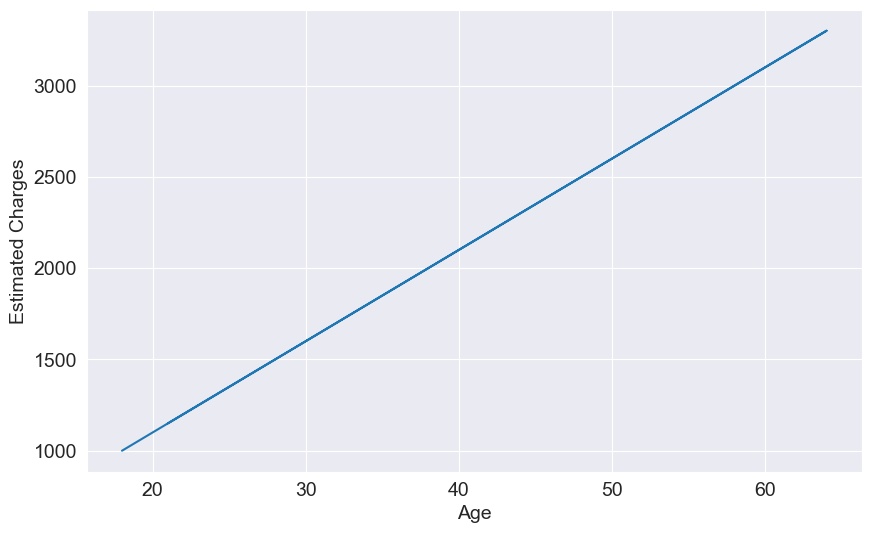

In [166]:
plt.plot(ages, estimated_charges);
plt.xlabel('Age');
plt.ylabel('Estimated Charges');

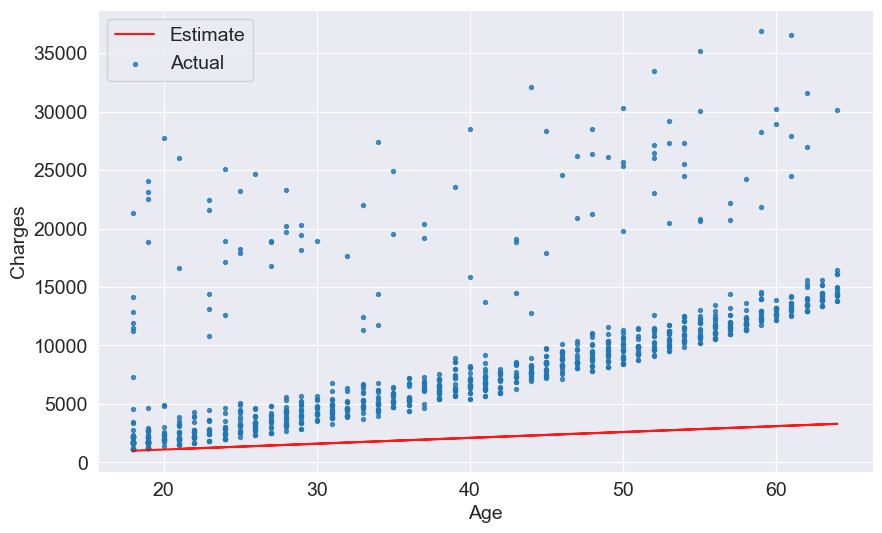

In [168]:
target = non_smoker_df.charges
#test
plt.plot(ages, estimated_charges, 'r', alpha=0.9);
plt.scatter(ages, target, s=8,alpha=0.8);
plt.xlabel('Age');
plt.ylabel('Charges')
plt.legend(['Estimate', 'Actual']);

In [170]:
def try_parameters(w, b):
    ages = non_smoker_df.age
    target = non_smoker_df.charges
    
    estimated_charges = estimate_charges(ages, w, b)
    
    plt.plot(ages, estimated_charges, 'r', alpha=0.9);
    plt.scatter(ages, target, s=8,alpha=0.8);
    plt.xlabel('Age');
    plt.ylabel('Charges')
    plt.legend(['Estimate', 'Actual']);

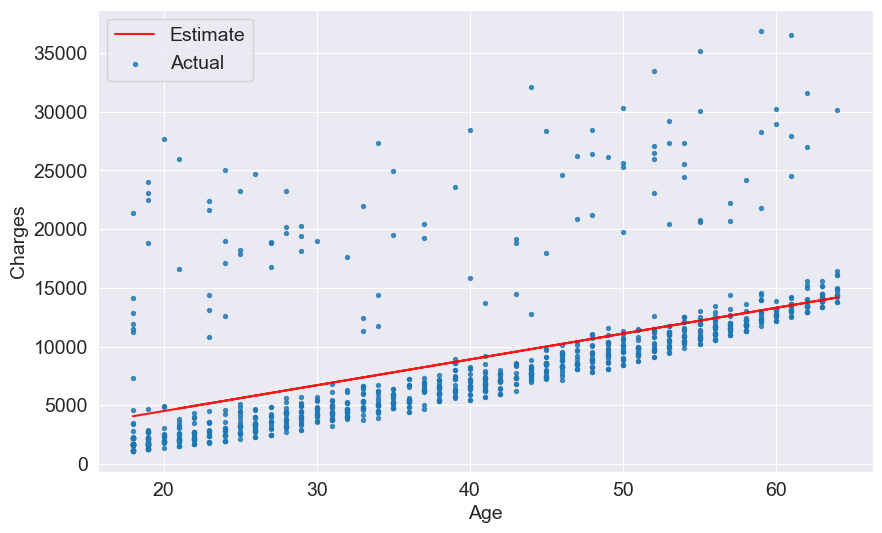

In [190]:
try_parameters(220, 100)

In [198]:
prediction = estimated_charges
prediction

1        4060
2        6260
3        7360
4        7140
5        6920
        ...  
1332    11540
1333    11100
1334     4060
1335     4060
1336     4720
Name: age, Length: 1064, dtype: int64

 Loss/Cost Function
We can compare our model's predictions with the actual targets using the following method:

Calculate the difference between the targets and predictions (the differenced is called the "residual")
Square all elements of the difference matrix to remove negative values.
Calculate the average of the elements in the resulting matrix.
Take the square root of the result
The result is a single number, known as the root mean squared error (RMSE). The above description can be stated mathematically as follows:

In [207]:
import numpy as np
def rmse(targets, predictions):
    return np.sqrt(np.mean(np.square(targets - predictions)))
targets = non_smoker_df['charges']
predicted = estimate_charges(non_smoker_df.age, w, b)
rmse(targets, predicted)

4721.288985595375

In [209]:
def try_parameters(w, b):
    ages = non_smoker_df.age
    target = non_smoker_df.charges
    predictions = estimate_charges(ages, w, b)
    
    plt.plot(ages, predictions, 'r', alpha=0.9);
    plt.scatter(ages, target, s=8,alpha=0.8);
    plt.xlabel('Age');
    plt.ylabel('Charges')
    plt.legend(['Prediction', 'Actual']);
    
    loss = rmse(target, predictions)
    pri nt("RMSE Loss: ", loss)

RMSE Loss:  4715.843358363601


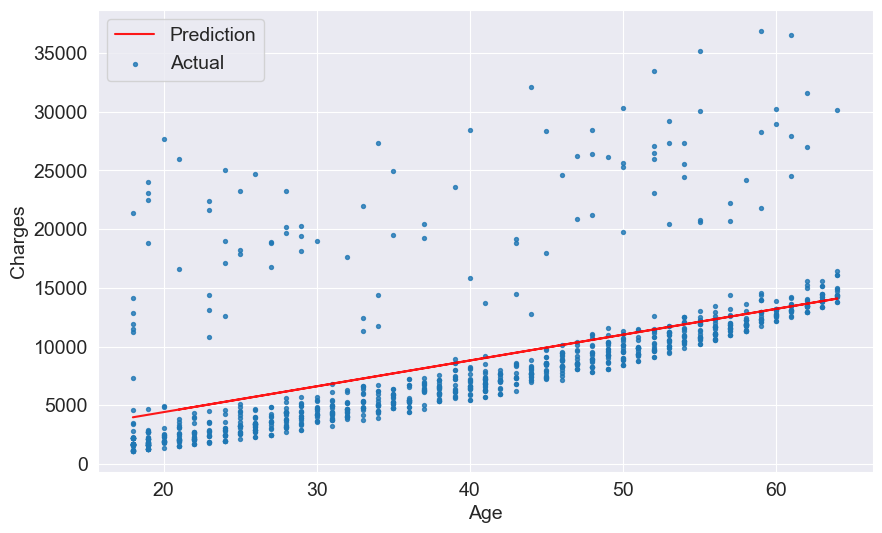

In [221]:
try_parameters(220, 10)

Linear Regression using Scikit-learn
In practice, you'll never need to implement either of the above methods yourself. You can use a library like scikit-learn to do this for you.

In [224]:
 !pip install scikit-learn --quiet

In [228]:
from sklearn.linear_model import LinearRegression

In [237]:
model = LinearRegression()


In [275]:
inputs = non_smoker_df[['age','bmi']]
targets = non_smoker_df['charges']
model.fit(inputs, targets)

LinearRegression()

In [267]:
predictions = model.predict(inputs)
predictions

array([2749.08516308, 5412.40282772, 6673.94368635, ..., 2735.99553127,
       2770.87763119, 3493.32334862])

In [269]:
rmse(targets,predictions)

4662.3128354612945

In [271]:
model.coef_

array([266.87657817,   7.07547666])

In [277]:
model.intercept_

-2293.6320906488654

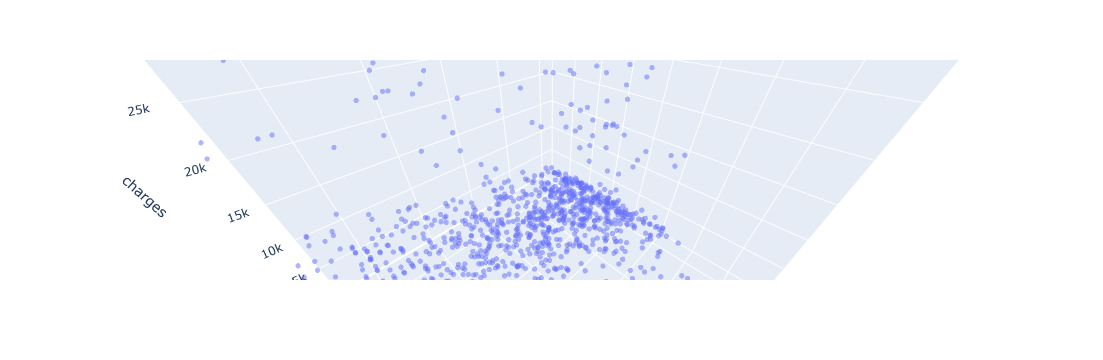

In [281]:
fig = px.scatter_3d(non_smoker_df, x='age', y='bmi', z='charges')
fig.update_traces(marker_size=3, marker_opacity=0.5)
fig.show()